# Build a structured grid model from scatch

This notebook shows the process of going from GIS data to an operational PRMS/pywatershed model of the Sagehen Creek Watershed, near Truckee, CA. In this notebook, we use functionality from `D-Any`, `FloPy`, and `pyGSFLOW` to construct an operational model of the basin.

The model that is created in this notebook is discretized with a structured grid which is compatible with older versions of MODFLOW and GSFLOW. 

This notebook does not cover in depth details of each of the functions that are used to construct the model. Instead it refers to other notebooks that cover the methods.

In [1]:
import os
import flopy
import dany
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path
from gsflow.builder import GenerateFishnet, PrmsBuilder, ControlFileBuilder
from flopy.plot import styles

from dataretrieval import nwis, nldi
from pyproj import Transformer

import warnings
from shapely.errors import ShapelyDeprecationWarning
warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning)
warnings.simplefilter("ignore", DeprecationWarning)
warnings.simplefilter("ignore", UserWarning)
pd.options.mode.chained_assignment = None

Define paths for input data and model outputs

In [2]:
data_ws = Path("../data")
output_ws = data_ws / "sagehen_structured_example"
dem_file = data_ws / "dem.img"
geospatial_ws = data_ws / "geospatial"

# soil rasters
awc = geospatial_ws / "awc.img"
ksat = geospatial_ws / "ksat.img"
clay = geospatial_ws / "clay.img"
sand = geospatial_ws / "sand.img"

# land cover rasters
nlcd2011 = geospatial_ws / "nlcd2011_imp_utm.img"
lf_cover = geospatial_ws / "us_140evc_utm.img"
lf_vegtype = geospatial_ws / "us_140evt_utm.img"

# climate rasters
ppt_rstrs = [geospatial_ws / f"climate/ppt_utm/PRISM_ppt_30yr_normal_800mM2_{i :02d}_bil.img" for i in range(1, 13)]
tmax_rstrs = [geospatial_ws / f"climate/tmax_utm/PRISM_tmax_30yr_normal_800mM2_{i :02d}_bil.img" for i in range(1, 13)]
tmin_rstrs = [geospatial_ws / f"climate/tmin_utm/PRISM_tmin_30yr_normal_800mM2_{i :02d}_bil.img" for i in range(1, 13)]

# climate csv files
station_data = geospatial_ws / "climate/sagehen_climate.csv"
lapse_data = geospatial_ws / "climate/sagehen_lapse_rates.csv"

Load the Digital Elevation Model (DEM) raster

In [3]:
rstr = flopy.utils.Raster.load(dem_file)

Create a bounding box of decimal latitude and longitude for the raster.

In [4]:
epsg_utm = rstr.crs.to_epsg()
epsg_wgs84 = 4326  # decimal lat lon
crs_utm = f"EPSG:{epsg_utm}"
crs_wgs84 = f"EPSG:{epsg_wgs84}"

transformer = Transformer.from_crs(crs_utm, crs_wgs84, always_xy=True)

Get decimal latitude longitude boundaries for the area of interest

In [5]:
xmin, xmax, ymin, ymax = rstr.bounds
xmin, ymin = transformer.transform(xmin, ymin)
xmax, ymax = transformer.transform(xmax, ymax)
wgs_bounds = [xmin, ymin, xmax, ymax]

Get gage information and basin boundary information for the basin using `dataretrieval`. This infomation will be used for building the model grid in subsequent steps

Get gage information for USGS streamgage [10343500](https://waterdata.usgs.gov/usa/nwis/inventory/?site_no=10343500&agency_cd=USGS)

In [6]:
info, meta = nwis.get_info(bBox=[f"{i :.2f}" for i in wgs_bounds])
info.to_crs(epsg=epsg_utm, inplace=True)
sitedf = info[info.site_no == "10343500"]
sitedf

,agency_cd,site_no,station_nm,site_tp_cd,lat_va,long_va,dec_lat_va,dec_long_va,coord_meth_cd,coord_acy_cd,...,reliability_cd,gw_file_cd,nat_aqfr_cd,aqfr_cd,aqfr_type_cd,well_depth_va,hole_depth_va,depth_src_cd,project_no,geometry
2,USGS,10343500,SAGEHEN C NR TRUCKEE CA,ST,392554.0,1201413.0,39.431572,-120.237979,M,F,...,NaN,NNNNNNNN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (221299.997 4369675.311)


Generate an initial model grid from the raster boundaries

In [7]:
cellsize = 75
grid = GenerateFishnet(bbox=rstr.bounds, xcellsize=cellsize, ycellsize=cellsize)

Plot the raster, `StructuredGrid`, and streamgage location for visual inspection

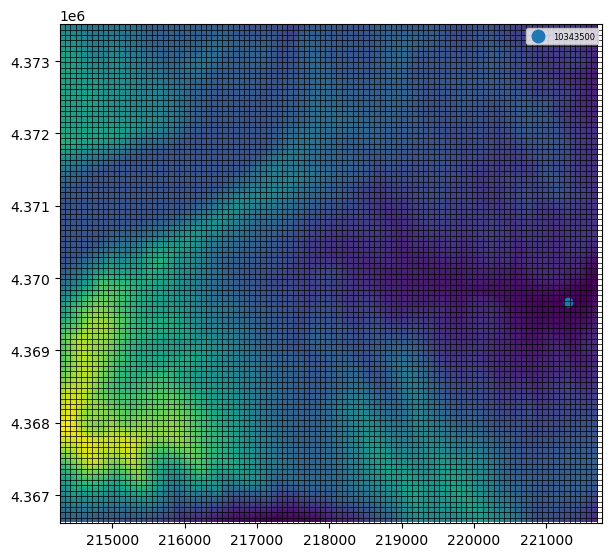

In [8]:
fig, ax = plt.subplots(figsize=(7, 7))
pmv = flopy.plot.PlotMapView(modelgrid=grid)
rstr.plot(ax=ax)
pmv.plot_grid(color="k", lw=0.5)
sitedf.plot(column="site_no", ax=ax, cmap="tab20", legend=True, legend_kwds={"fontsize": 6});

#### Resample the raster to the structured mesh
`FloPy`'s raster class has a built in method that can be used for geostatical resampling of rasters to a grid discretization. To learn more about this please see [Flopy Raster example](https://flopy.readthedocs.io/en/latest/Notebooks/raster_intersection_example.html)

In [9]:
rstr = flopy.utils.Raster.load(dem_file)
resampled_dem = rstr.resample_to_grid(
    grid,
    band=rstr.bands[0],
    method="min"
)

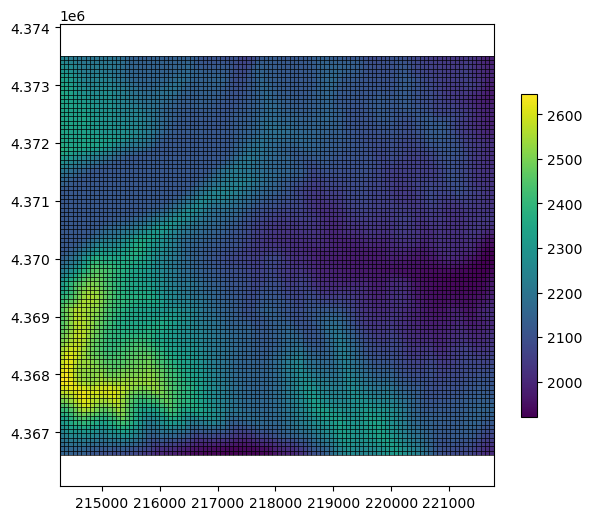

In [10]:
# plot the grid and the resampled dem
fig, ax = plt.subplots(figsize=(7, 6))
ax.axis("equal")
pmv = flopy.plot.PlotMapView(modelgrid=grid, ax=ax)
pc = pmv.plot_array(resampled_dem)
pmv.plot_grid(color="k", lw=0.5)
plt.colorbar(pc, shrink=0.7);

### Hydrologic conditioning

Hydrologic conditioning can be done with `dany.fill_sinks()`. This method uses a modified improved-epsilon priority flood sink filling method to condition the digital elevations. More information about this process can be found in the "Hydrologic_conditioning" notebook.

In [11]:
conditioned_dem = dany.fill_sinks(grid, resampled_dem)
conditioned_dem = dany.fill_nan_values(grid, conditioned_dem)

### Flow directions and flow accumulation

Flow directions and flow accumulation can be calculated using the `dany.FlowDirections` class. This class uses the "D-Any" algorithm to calculate flow directions. For more information on this process, see the "Flow directions and accumulation" notebook. 

In [12]:
fdobj = dany.FlowDirections(grid, conditioned_dem)
fdirs = fdobj.flow_directions()
facc = fdobj.flow_accumulation(as_cells=True)

# get the flow direction vectors
qx, qy = fdobj.vectors

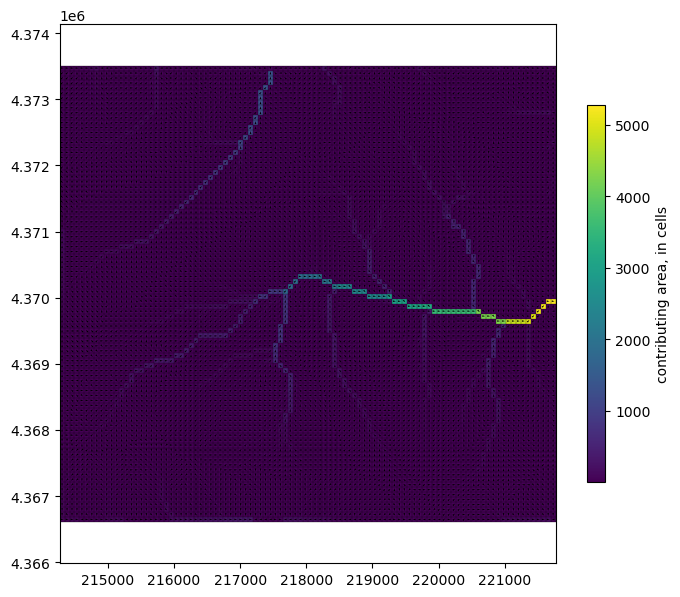

In [13]:
# plot the flow directions and flow accumulation array
fig, ax = plt.subplots(figsize=(8, 7))
ax.axis("equal")
pmv = flopy.plot.PlotMapView(modelgrid=grid, ax=ax)
pc = pmv.plot_array(facc)
pmv.plot_vector(qx, qy)
pmv.plot_grid(color="k", lw=0.2)
plt.colorbar(pc, shrink=0.7, label="contributing area, in cells");

#### Delineate the watershed

The `dany.FlowDirections` class can be used to delineate watersheds and define the active extent of a model. The `get_watershed_boundary()` method is used to create a binary mask of active and inactive cells based on the cells that drain to a location such as a streamgage.

In [14]:
watershed = fdobj.get_watershed_boundary(sitedf.geometry.values[0])

Plot the folow accumulation within the active extent of the model

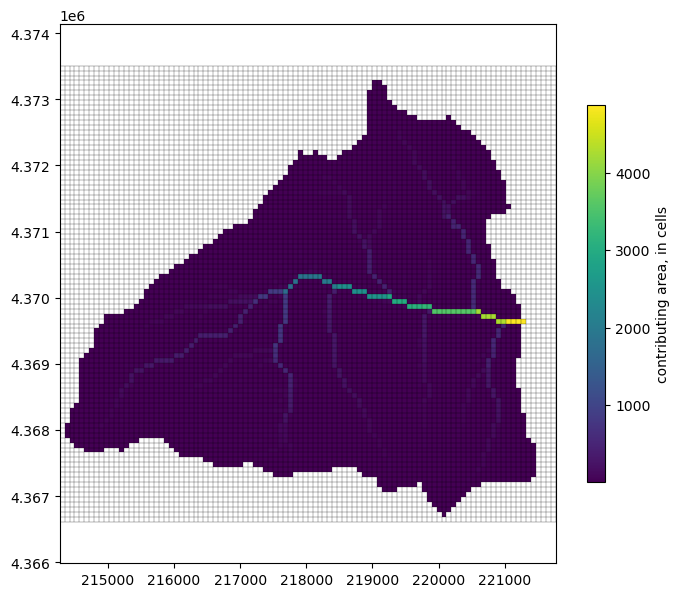

In [15]:
active_fa = facc.copy()
active_fa[watershed == 0] = np.nan 

# plot the flow directions and flow accumulation array
fig, ax = plt.subplots(figsize=(8, 7))
ax.axis("equal")
pmv = flopy.plot.PlotMapView(modelgrid=grid, ax=ax)
pc = pmv.plot_array(active_fa)
pmv.plot_grid(color="k", lw=0.2)
plt.colorbar(pc, shrink=0.7, label="contributing area, in cells");

#### Generate the stream network

The `dany.PrmsStreams` class can be used to generate stream networks and produce PRMS input data including stream parameters and cascades. More information on this process can be found in the "Generating stream networks" notebook example

In [16]:
prms_streams = dany.PrmsStreams(grid, fdobj)

In [17]:
contrib_area = 150
strm_array = prms_streams.delineate_streams(contrib_area, basin_boundary=watershed)
strm_array_cp = strm_array.copy().astype(float)
strm_array_cp[watershed == 0] = np.nan

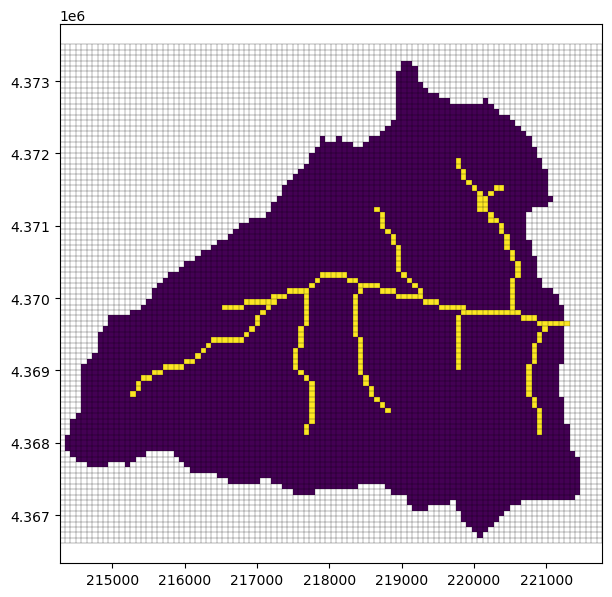

In [18]:
# plot the flow directions and flow accumulation array
fig, ax = plt.subplots(figsize=(7, 7))
ax.axis("equal")
pmv = flopy.plot.PlotMapView(modelgrid=grid, ax=ax)
pc = pmv.plot_array(strm_array_cp)
pmv.plot_grid(color="k", lw=0.2);

#### Create a pyGSFLOW compatible cascade object

`D-Any` has built in compatibility support for `pygsflow` builder workflows like `gsflow.builder.PrmsBuilder()`. For more information about this method and the resulting object that's returned, see the "Generating stream networks" notebook.

In [19]:
pgsf_cascades = prms_streams.get_pygsflow_builder_object(
    strm_array,
    group_segments=True,
    basin_boundary=watershed
)
pgsf_cascades.__dict__

{'dany_flag': True,
 'ncascade': 7511,
 'hru_up_id': array([ 364,  464,  365, ..., 8979, 8978, 9078]),
 'hru_down_id': array([ 465,  465,  466, ..., 8880, 8979, 8979]),
 'hru_pct_up': array([1., 1., 1., ..., 1., 1., 1.]),
 'hru_strmseg_down_id': array([0, 0, 0, ..., 0, 0, 0]),
 'cascade_flag': 1,
 'hru_slope': array([ 0.12764323,  0.24550456,  0.14373698, ...,  0.18315592,
         0.01349772, -0.01349772]),
 'hru_aspect': array([  0.,   0.,   0., ...,   0.,   0., 180.]),
 'hru_area': array([5625., 5625., 5625., ..., 5625., 5625., 5625.]),
 'nsegments': 19,
 'nreaches': 224}

#### Create input files using pyGSFLOW's `PrmsBuilder()`.

At this point enough information about the surface water system has been generated to build an initial PRMS parameter file with pyGSFLOW's builder classes. Detailed information about the `PrmsBuilder()` class and the related `PrmsParameter` object it creates can be found here: [pyGSFLOW PrmsBuilder](https://github.com/pygsflow/pygsflow/blob/develop/examples/pygsflow1.1.0_Builder_tutorial_07_PrmsBuilder.ipynb)

In [20]:
prms_builder = PrmsBuilder(
    None,
    pgsf_cascades,
    grid,
    conditioned_dem.ravel(),
    hru_type=watershed
)

In [21]:
parameters = prms_builder.build()
parameters

### Use pyGSFLOW and FloPy to add additional parameter information to the Parameter file

The rest of this exercise uses pyGSFLOW and FloPy to finish building an operational PRMS model. For more information on this, see the pyGSFLOW builder examples located here: [pyGSFLOW examples](https://github.com/pygsflow/pygsflow/tree/develop/examples)

In [22]:
import gsflow
import gsflow.builder.builder_utils as bu

# create a path to the pygsflow remap files
gsf_ws = Path(gsflow.__file__).parent
remap_ws = gsf_ws / "../examples/data/remaps/landfire"

Set hru latitude and longitude

In [23]:
gdf_grid = grid.geo_dataframe
gdf_grid.set_crs(epsg_utm, inplace=True)
gdf_grid.to_crs(epsg_wgs84, inplace=True)

parameters.set_values("hru_lat", gdf_grid.centroid.y.values)
parameters.set_values("hru_lon", gdf_grid.centroid.x.values)

array([-120.32072179, -120.31985141, -120.31898103, ..., -120.23344761,
       -120.23257788, -120.23170814])

Resample land use, soil rasters, and climate rasters to create input parameters

In [24]:
raster = flopy.utils.Raster.load(lf_cover)
veg_cov = raster.resample_to_grid(
    grid,
    band=raster.bands[0],
    method="nearest",
)
veg_cov = veg_cov.astype(int)

In [25]:
raster = flopy.utils.Raster.load(lf_vegtype)
veg_type = raster.resample_to_grid(
    grid,
    band=raster.bands[0],
    method="nearest",
)
veg_type = veg_type.astype(int)

In [26]:
raster = flopy.utils.Raster.load(awc)
awc = raster.resample_to_grid(
    grid,
    band=raster.bands[0],
    method="median",
)
awc[awc == raster.nodatavals[0]] = np.nanmedian(awc)

In [27]:
raster = flopy.utils.Raster.load(ksat)
ksat = raster.resample_to_grid(
    grid,
    band=raster.bands[0],
    method="median",
)
ksat[ksat == raster.nodatavals[0]] = np.nanmedian(ksat)

In [28]:
raster = flopy.utils.Raster.load(sand)
sand = raster.resample_to_grid(
    grid,
    band=raster.bands[0],
    method="median",
)
sand[sand == raster.nodatavals[0]] = np.nanmedian(sand)
sand /= 100

In [29]:
raster = flopy.utils.Raster.load(clay)
clay = raster.resample_to_grid(
    grid,
    band=raster.bands[0],
    method="median",
)
clay[clay == raster.nodatavals[0]] = np.nanmedian(clay)
clay /= 100

In [30]:
raster = flopy.utils.Raster.load(nlcd2011)
impervious = raster.resample_to_grid(
    grid,
    band=raster.bands[0],
    method="median",
)
impervious /= 100

In [31]:
ppt = []
for rstr in ppt_rstrs:
    raster = flopy.utils.Raster.load(rstr)
    tppt = raster.resample_to_grid(
        grid,
        band=raster.bands[0],
        method="linear",
    )
    ppt.append(tppt.ravel())
ppt = np.array(ppt)

In [32]:
tmin = []
for rstr in tmin_rstrs:
    raster = flopy.utils.Raster.load(rstr)
    ttmin = raster.resample_to_grid(
        grid,
        band=raster.bands[0],
        method="linear",
    )
    tmin.append(ttmin.ravel())
tmin = np.array(tmin)

In [33]:
tmax = []
for rstr in tmax_rstrs:
    raster = flopy.utils.Raster.load(rstr)
    ttmax = raster.resample_to_grid(
        grid,
        band=raster.bands[0],
        method="linear",
    )
    tmax.append(ttmax.ravel())
tmax = np.array(tmax)

Load the pygsflow remap files

In [34]:
covtype_lut = bu.build_lut(remap_ws / "covtype.rmp")
covden_sum_lut = bu.build_lut(remap_ws / "covdensum.rmp")
covden_win_lut = bu.build_lut(remap_ws / "covdenwin.rmp")
root_depth_lut = bu.build_lut(remap_ws / "rtdepth.rmp")
snow_intcp_lut = bu.build_lut(remap_ws / "snow_intcp.rmp")
srain_intcp_lut = bu.build_lut(remap_ws / "srain_intcp.rmp")

Build vegetative cover parameters

In [35]:
covtype = bu.covtype(veg_type, covtype_lut)
covden_sum = bu.covden_sum(veg_cov, covden_sum_lut)
covden_win = bu.covden_win(covtype.values, covden_win_lut)
rad_trncf = bu.rad_trncf(covden_win.values)
snow_intcp = bu.snow_intcp(veg_type, snow_intcp_lut)
srain_intcp = bu.srain_intcp(veg_type, srain_intcp_lut)
wrain_intcp = bu.wrain_intcp(veg_type, snow_intcp_lut)

Add vegetative cover to param_obj

In [36]:
parameters.add_record_object(covtype, True)
parameters.add_record_object(covden_sum, True)
parameters.add_record_object(covden_win, True)
parameters.add_record_object(rad_trncf, True)
parameters.add_record_object(snow_intcp, True)
parameters.add_record_object(srain_intcp, True)
parameters.add_record_object(wrain_intcp, True)

Build soil parameters

In [37]:
hru_slope = fdobj.slope
hru_aspect = fdobj.aspect
hru_len = fdobj.hru_len
nhru = parameters.nhru.values[0]

root_depth = bu.root_depth(veg_type, root_depth_lut)
soil_type = bu.soil_type(clay, sand)
soil_moist_max = bu.soil_moist_max(awc, root_depth)
soil_moist_init = bu.soil_moist_init(soil_moist_max.values)
soil_rech_max = bu.soil_rech_max(awc, root_depth)
ssr2gw_rate = bu.ssr2gw_rate(ksat, sand, soil_moist_max.values)
ssr2gw_sq = bu.ssr2gw_exp(nhru)
soil_rech_init = bu.soil_rech_init(soil_rech_max.values)
slowcoef_lin = bu.unstructured_slowcoef_lin(ksat, hru_aspect, hru_len)
slowcoef_sq = bu.unstructured_slowcoef_sq(
    ksat,
    hru_aspect,
    sand,
    soil_moist_max.values,
    hru_len
)

Add soil parameters

In [38]:
parameters.add_record_object(soil_type, replace=True)
parameters.add_record_object(soil_moist_max, replace=True)
parameters.add_record_object(soil_moist_init, replace=True)
parameters.add_record_object(soil_rech_max, replace=True)
parameters.add_record_object(soil_rech_init, replace=True)
parameters.add_record_object(ssr2gw_rate, replace=True)
parameters.add_record_object(ssr2gw_sq, replace=True)
parameters.add_record_object(slowcoef_lin, replace=True)
parameters.add_record_object(slowcoef_sq, replace=True)

Create imperviousness parameters

In [39]:
impervious[np.isnan(impervious)] = np.nanmean(impervious)
hru_percent_imperv = bu.hru_percent_imperv(impervious)
carea_max = bu.carea_max(impervious)

Add imperviousness parameters

In [40]:
parameters.add_record_object(hru_percent_imperv, replace=True)
parameters.add_record_object(carea_max, replace=True)

Add runoff observation parameters

In [41]:
parameters.add_record(name="nobs", values=[1, ])
outlet_sta = np.nanargmin(conditioned_dem)

parameters.add_record(
        "outlet_sta",
        values=[1,],
        dimensions=[["one", 1]],
        datatype=1
)
parameters.add_record(
    "id_obsrunoff",
    values=[outlet_sta + 1,],
    dimensions=[["one", 1]],
    datatype=1
)

Read in climate station and lapse rate data

In [42]:
climdf = pd.read_csv(station_data)
lapsedf = pd.read_csv(lapse_data)

In [43]:
climdf = bu.add_prms_date_columns_to_df(climdf, "date")
climdf.rename(
    columns={
        'precip': 'precip_0',
        'tmin': 'tmin_0',
        'tmax': 'tmax_0',
        'runoff': 'runoff_0',
        'date': 'Date'
    },
    inplace=True
)
# reorder dataframe to later build a prms Data object from it
climdfcols = [
    "Year", "Month", "Day", "Hour", "Minute", "Second",
    "tmax_0", "tmin_0", "precip_0", "runoff_0", "Date"
]
climdf = climdf[climdfcols]

Build climate parameters

In [44]:
mean_ppt = bu.get_mean_monthly_from_df(climdf, 'precip_0')
climdf["tmax_0"] = bu.fahrenheit_to_celsius(climdf["tmax_0"].values)
climdf["tmin_0"] = bu.fahrenheit_to_celsius(climdf["tmin_0"].values)
mean_tmax = bu.get_mean_monthly_from_df(climdf, "tmax_0", temperature=True)
mean_tmin = bu.get_mean_monthly_from_df(climdf, "tmin_0", temperature=True)

rain_adj = bu.rain_adj(ppt, mean_ppt)
snow_adj = bu.snow_adj(ppt, mean_ppt)

tmin_lapse = bu.tmin_lapse(lapsedf.tmin_lapse.values * (5 / 9))
tmax_lapse = bu.tmax_lapse(lapsedf.tmax_lapse.values * (5 / 9))

tmax_adj = bu.tmax_adj(nhru)
tmin_adj = bu.tmin_adj(nhru)

jh_coef = bu.calculate_jensen_haise(conditioned_dem, mean_tmin, mean_tmax)

Add climate parameters to parameter object

In [45]:
parameters.add_record_object(rain_adj, replace=True)
parameters.add_record_object(snow_adj, replace=True)
parameters.add_record_object(tmin_lapse, replace=True)
parameters.add_record_object(tmax_lapse, replace=True)
parameters.add_record_object(tmax_adj, replace=True)
parameters.add_record_object(tmin_adj, replace=True)
parameters.add_record_object(jh_coef, replace=True)
parameters.add_record(
    "tsta_elev",
    values=[1932.4,],
    dimensions=[["ntemp", 1]],
    datatype=2
)

Build the PRMS data object

In [46]:
prmsdata = gsflow.prms.PrmsData(data_df=climdf)

#### Build the remainder of the PRMS model

The following code blocks build the PRMS model, control file, and link it all together with the `GsflowModel` class. Please see the pyGSFLOW examples for more info: [pygsflow examples](https://github.com/pygsflow/pygsflow/tree/develop/examples)

In [47]:
control_obj = gsflow.builder.ControlFileBuilder().build("saghen_structured_example", parameters, None)
prms = gsflow.prms.PrmsModel(control_obj, parameters=parameters, data=prmsdata)
gsf = gsflow.GsflowModel(control=control_obj, prms=prms, mf=None)

Make parameter adjustments in the control file

In [48]:
gsf.control.set_values("start_time", [1982, 10, 1, 0, 0, 0])
gsf.control.set_values("srunoff_module", values=["srunoff_smidx"])
gsf.control.set_values("model_mode", values=["PRMS5"])  # set PRMS only model
gsf.control.set_values("subbasin_flag", values=[0, ])
gsf.control.set_values("parameter_check_flag", values=[1, ])

Add a few additional Control file parameters

In [49]:
gsf.control.add_record("end_time", values=[1996, 9, 31, 0, 0, 0])
gsf.control.add_record("print_debug", values=[0, ])
gsf.control.add_record("modflow_time_zero", values=[1982, 10, 1, 0, 0, 0])
gsf.control.add_record("data_file", values=["sagehen_structured_example.data", ])
gsf.control.add_record("gwr_swale_flag", values=[1,])
gsf.control.add_record("statsON_OFF", values=[1])
gsf.control.add_record("nstatVars", values=[6])
gsf.control.add_record("statVar_element",
                       values=["1", "1", "1", "1", "1", "1"])
gsf.control.add_record("statVar_names",
                       values=["runoff",
                               "basin_cfs",
                               "basin_ssflow_cfs",
                               "basin_gwflow_cfs",
                               "basin_sroff_cfs",
                               "basin_dunnian"])

gsf.control.add_record("stat_var_file", values=["statvar.dat"])

##### Write the initial model, prior to hand calibration adjustments

In [50]:
output_ws.mkdir(exist_ok=True)
gsf.write_input(basename="sagehen_structured_example", workspace=str(output_ws))

Writing the project files .....
Writing Control file ...
Writing Parameters files ...
Writing Data file ...


#### Calibrate the model

In [51]:
hc_ws = output_ws / "hand_cal"
hc_ws.mkdir(exist_ok=True)

Temperatue adjustments

In [52]:
gsf.prms.parameters.tmin_lapse += 1.2
gsf.prms.parameters.tmax_lapse += 1.2

Snow/snowmelt adjustments

In [53]:
gsf.prms.parameters.tmax_allsnow[:] = 0.7
gsf.prms.parameters.add_record(
    "tmax_allrain_offset", values=[3.9,] * 12, dimensions=[["nmonths", 12]]
)
gsf.prms.parameters.rad_trncf[:] = 0.8 * gsf.prms.parameters.covden_win.values
gsf.prms.parameters.snowinfil_max[:] = 20

Soil Adjustments

In [54]:
gsf.prms.parameters.soil_moist_max *= 0.129
gsf.prms.parameters.add_record(
    "jh_coef", values=[0.03,] * 12, dimensions=[('nmonths', 12)]
)

runoff generation parameter adjustments

In [55]:
gsf.prms.parameters.smidx_coef /= 100
gsf.prms.parameters.smidx_exp /= 100
gsf.prms.parameters.carea_max /= 100

interflow parameter adjustments

In [56]:
gsf.prms.parameters.slowcoef_sq *= 0.388
gsf.prms.parameters.slowcoef_lin *= 2.832

groundwater recharge parameter adjustments

In [57]:
gsf.prms.parameters.ssr2gw_rate *= 0.006
gsf.prms.parameters.sat_threshold[:] = 629.30

groundwater exchange parameter adjustments

In [58]:
gsf.prms.parameters.gwflow_coef[:] = 0.08
gsf.prms.parameters.gwsink_coef[:] = 0.02

In [59]:
gsf.write_input(basename="sagehen_structured_example", workspace=str(hc_ws))
gsf.run_model(gsflow_exe="gsflow.exe", silent=True)

Writing the project files .....
Writing Control file ...
Writing Parameters files ...
Writing Data file ...


(False, [])

#### Get the output and evaluate outflows

In [60]:
from nse_util import nash_sutcliffe_efficiency
stats = gsf.prms.get_StatVar()
stats = stats[1096:]
stats.reset_index(inplace=True, drop=True)

gw_seepage = stats.basin_cfs_1.values.copy() - (
        stats.basin_ssflow_cfs_1.values.copy() +
        stats.basin_sroff_cfs_1.values.copy() +
        stats.basin_dunnian_1.values.copy()
)
stats.head()

Loading the statvar output file .....
Finished Load the statvar output file .....


,ID,Year,Month,Day,Hour,Minute,Second,runoff_1,basin_cfs_1,basin_ssflow_cfs_1,basin_gwflow_cfs_1,basin_sroff_cfs_1,basin_dunnian_1,Date
0,1097,1985,10,1,0,0,0,3.2,1.498,0.11760,1.380,0.0,0.0,1985-10-01
1,1098,1985,10,2,0,0,0,3.2,1.469,0.10970,1.359,0.0,0.0,1985-10-02
2,1099,1985,10,3,0,0,0,3.2,1.441,0.10230,1.338,0.0,0.0,1985-10-03
3,1100,1985,10,4,0,0,0,3.2,1.413,0.09546,1.317,0.0,0.0,1985-10-04
4,1101,1985,10,5,0,0,0,3.2,1.385,0.08926,1.296,0.0,0.0,1985-10-05


In [61]:
nse = nash_sutcliffe_efficiency(
    stats.basin_cfs_1.values, stats.runoff_1.values
)
nse

0.7557577602102055

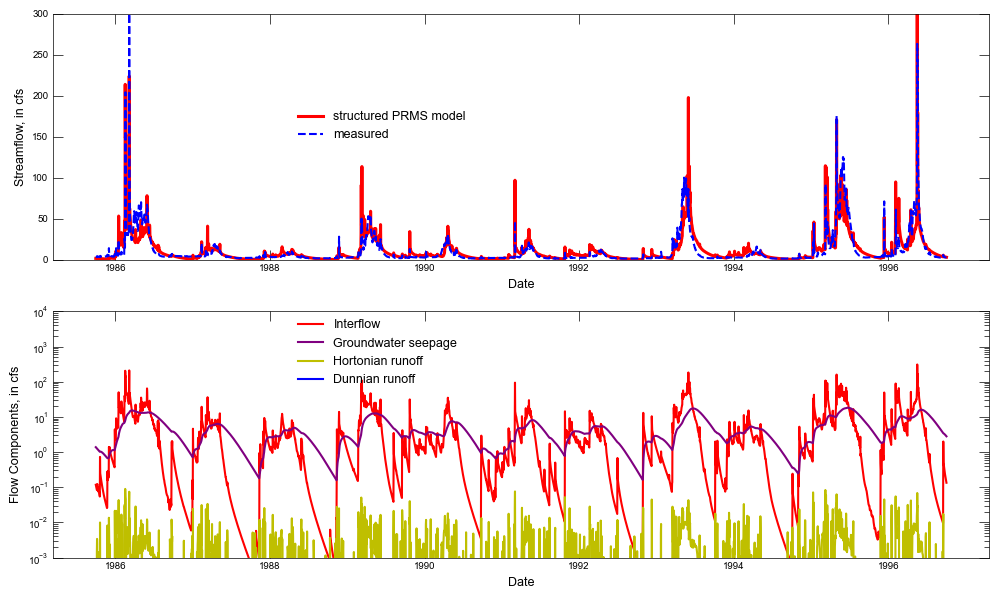

In [62]:
with styles.USGSMap():
    fig, axis = plt.subplots(2, 1, figsize=(10, 6))
    plt.rcParams.update({'font.size': 100})
    axis[0].plot(stats.Date.values, stats.basin_cfs_1.values, color='r', linewidth=2.2, label='structured PRMS model')
    axis[0].plot(stats.Date.values, stats.runoff_1.values, '--', color='b', linewidth=1.5, label='measured')
    handles, labels = axis[0].get_legend_handles_labels()
    axis[0].legend(handles, labels, bbox_to_anchor=(0.25, 0.65))
    axis[0].set_xlabel("Date")
    axis[0].set_ylabel("Streamflow, in cfs")
    axis[0].set_ylim(0, 300)

    plt.xlabel("Date")
    plt.ylabel("Streamflow, in cfs")
    plt.ylim(0, 300)

with styles.USGSMap():

    axis[1].set_xlabel("Date")
    axis[1].set_ylabel("Flow Components, in cfs")
    axis[1].set_yscale("log")
    plt.xlabel("Date")
    plt.ylabel("Flow Components, in cfs")
    plt.yscale("log")
    plt.ylim(1.0e-3, 1.0e4)
    axis[1].plot(stats.Date.values, stats.basin_ssflow_cfs_1.values, color='r', linewidth=1.5, label='Interflow')
    axis[1].plot(stats.Date.values, gw_seepage, color='purple', linewidth=1.5, label='Groundwater seepage')
    axis[1].plot(stats.Date.values, stats.basin_sroff_cfs_1.values, color='y', linewidth=1.5, label='Hortonian runoff')
    axis[1].plot(stats.Date.values, stats.basin_dunnian_1.values, color='b', linewidth=1.5, label='Dunnian runoff')
    handles, labels = axis[1].get_legend_handles_labels()
    axis[1].legend(handles, labels, bbox_to_anchor=(0.25, 0.65))
    plt.tight_layout()
    plt.show()